# Outline
Download all audio files from kaggle, label them

EDA
1. take a real audio, analyze it with graphs
2. take a fake audio, analyze it with graphs
3. learn all the different ways of analyzing an audio graph
4. Write comparisons and observations between the two

ML
1. Create a huge dataset that has all extracted features of all audio samples, labeled as real = 0, fake = 1
2. split, do cross validation on training
3. Run some models on it
4. use less features, use more features, research the features useful

Frontend
1. make an app or product
2. upload a file, have the script extract the features, then pass these extracted features into the best model, generate an overall prediction

If time permits
1. You can take this framework, scale it, and make it catered to anyone's voice, as long as there is data for real voice and data for fake voice
2. If this framework is scaled enough, it can be trained on millions of samples and be generalized

## Notes

- If an audio sample sounds not fake to me, but the computer says its fake, explain why. (Model Explanability)

- comparing human generated data to computer generated data.
    - understand how deepfake models generate fake voice data
    - make a catered dataset that we have control over, no bgm, mic control, make my own data and analyze it, maybe deepfake models create random noise when there is bgm or low audio quality

- find bad examples too, diverse dataset, low audio quality
    - Neural network will likely almost always perform well, if this is the case, we can explain why. If not, then cool, neural network sucks at differentiating low audio quality deepfakes etc. Explain why.

- Understand what features are being extracted from audio (what is a MFCC? etc)
    - How do each of the features explain fake or not fake audio (shap)


## Todos
- Importance of predictors may be different based on who is speaking, and how they are conducting themselves
    - female/male pitch, cadence
    - men vs women feature ranking

- train two different models, one on male, one on female, plot the feature importance, see if the features are different across male/female
    - see if male model generalizes to female model

- male/female models (these models are only trained on fake/real male/female data)
    - look at samples, only use fake samples that sound super real to me
    - fake samples that sound real list
        - male
            - taylor-to-linus
            - linus-to-musk
            - linus-to-ryan
        - female
            - taylor-to-margot
            - linus-to-taylor
            - linus-to-margot
    - train/validate the male model on real and fake linus/musk/ryan audio
        - test this model on real/fake taylor/margot audio

# New Notes
- margot-to-taylor
    - deepfake models seem to struggle with accents. Margot has a british accent, and when it tries to make that audio sound like taylor's voice, the accent stays. This fake audio sample also does not sound too good in general. (here, the deepfake model is given margot's audio sample, and it is told to make margot sound like taylor)
- linus-to-ryan
    - deepfake models seem to be able to work well with sparse data. In the original Ryan audio, his voice is echoey, as he is talking on stage with a mic at the golden globe awards. However, in the audio sample that linus records, it has no background audio and it is a clear stream of audio. The deepfake model is able to take that and essentially remove the echo, and isolate ryan's voice as well as his "raspiness" to impersonate linus' audio style in the linus recording. (here, the deepfake model is given linus' audio sample, and it is told to make linus sound like ryan. The deepfake model only has echoey ryan audio to work with.)

### What is an MFCC and why is it important

Mel-Frequency Cepstral Coefficients (MFCCs) are commonly used features in audio processing, especially for tasks like speech and sound classification. They are derived by first performing a Short-Time Fourier Transform (STFT), which breaks the audio signal into short frames to analyze frequency content over time. These frequencies are then mapped onto the Mel scale, a perceptual scale that reflects how humans hear pitch, emphasizing lower frequencies where our ears are more sensitive. A logarithm is applied to mimic human perception of loudness, followed by a Discrete Cosine Transform (DCT) to reduce redundancy and compress the information into a set of compact coefficients. MFCCs effectively capture the timbre and spectral shape of audio, making them valuable for distinguishing between different types of sounds, such as real versus fake audio.

### How Librosa Gets One Value (one MFCC coefficient in one frame):

1. Frame the audio

    - Slice the 1-second signal into short overlapping frames (e.g., 25 ms windows with 10 ms hop).

    - One column corresponds to one frame (about 512 samples per frame if sampling at 22,050 Hz).

2. Apply a window function

    - Multiply the frame by a window (like Hann) to reduce edge effects.

3. Take the Fourier Transform (STFT)

    - Get the power spectrum (frequency content) of the frame.

4. Map to Mel scale

    - Apply Mel filterbanks to focus on how humans hear frequency (more resolution at low frequencies).

    - Sum the energy under each Mel filter — gives a vector of Mel-band energies.

5. Take log of Mel energies

    - Humans perceive loudness on a logarithmic scale — so apply log().

6. Apply Discrete Cosine Transform (DCT)

    - Compress the information into fewer coefficients.

    - The first 20 DCT coefficients (defined in the code with n_mfcc in librosa) become your MFCC vector.

So, MFCC1 - MFCC20 are from the respective 20 DCT coefficients from the log-Mel spectrum of that frame.

### What is rolloff and why is it important

Rolloff is a feature that represents the frequency below which a specified percentage (usually 85%) of the total spectral energy is contained, which summarizes the distribution of energy across frequencies in an audio signal. It serves as a measure of audio brightness, with higher rolloff values indicating more high-frequency content. In fake vs. real audio detection, spectral rolloff is important because synthetic audio often exhibits unnatural spectral characteristics—such as inconsistent energy distribution or excessive high-frequency content—due to imperfections in generative models. Real human speech tends to produce smoother and more consistent rolloff patterns, making rolloff a useful feature for identifying artifacts and anomalies indicative of deepfakes.

Import all necessary packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import librosa
import librosa.feature
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import numpy as np
import os
import seaborn as sns

Mounted at /content/drive


In [ ]:
# Load audio file
y, sr = librosa.load('/content/drive/My Drive/LING_199/linus-original-DEMO.mp3', sr=None)

In [ ]:
# Extract some features from a sample audio
# returns numpy arrays
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
rms = librosa.feature.rms(y=y)
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20) # use 20 coefficients

# Create time axis
time = np.linspace(0, len(y) / sr, num=len(y))

In [ ]:
print(f"Sample rate: {sr}")
print(f"Duration in seconds: {len(y) / sr}")
print(f"Max time value: {max(time)}")

Sample rate: 44100
Duration in seconds: 60.0
Max time value: 60.0


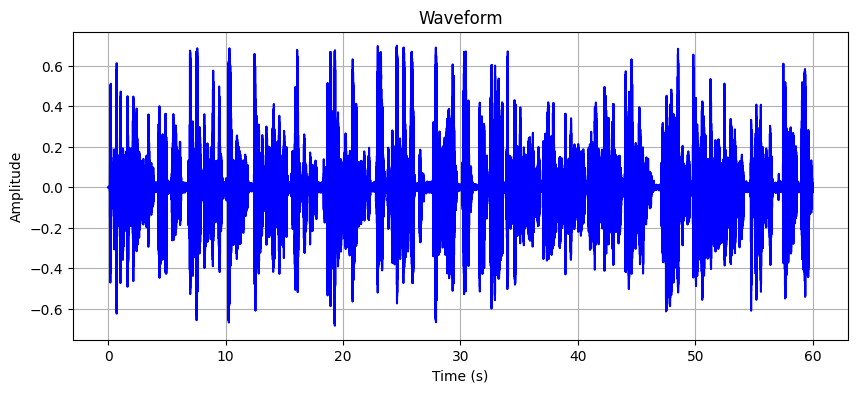

In [ ]:
# Plot waveform of amplitude over time
plt.figure(figsize=(10, 4))
plt.plot(time, y, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid()
plt.show()

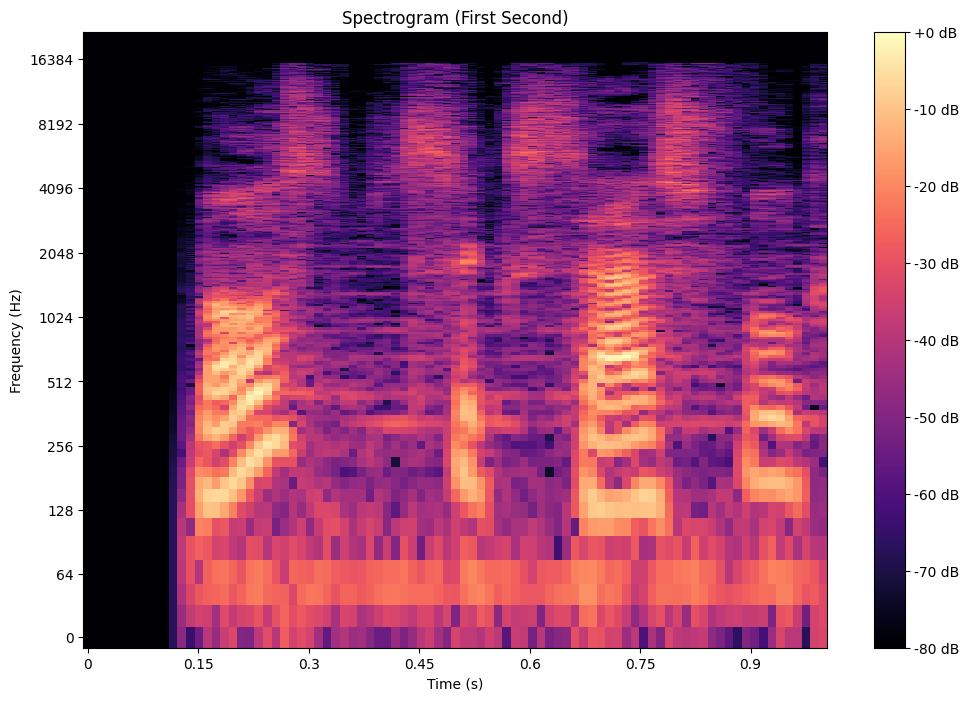

In [ ]:
# Limit to the first 10 seconds
y_1s = y[:1 * sr]  # First second of audio

# Compute the short-time Fourier transform (STFT)
D = librosa.stft(y_1s)

# Convert the amplitude to decibels (log scale)
DB = librosa.amplitude_to_db(abs(D), ref=np.max)

# Plot the spectrogram for the first 10 seconds
plt.figure(figsize=(12, 8))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (First Second)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

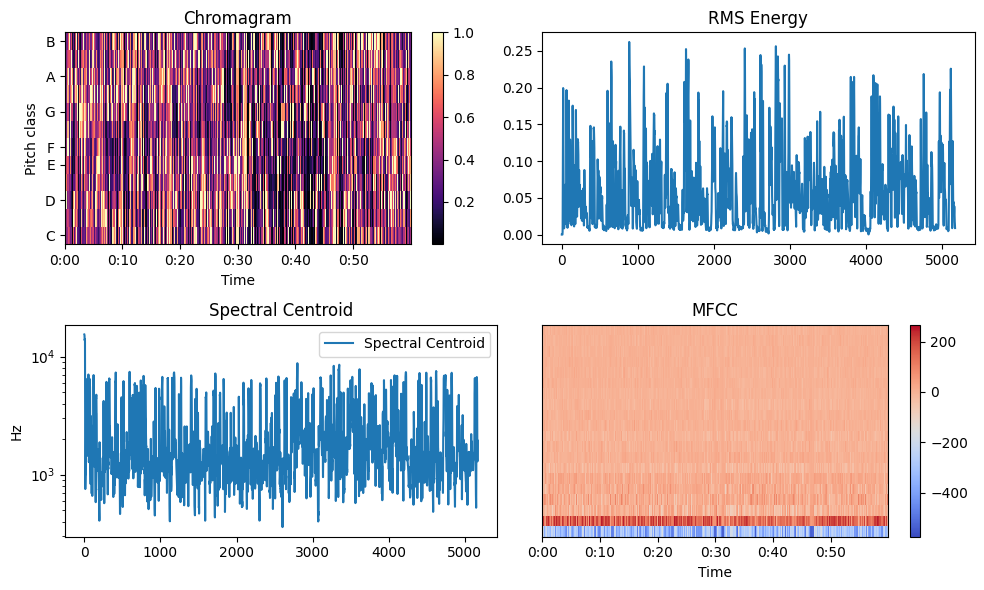

In [ ]:
plt.figure(figsize=(10, 6))

# Plot Chromagram
plt.subplot(2, 2, 1)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.title('Chromagram')

# Plot RMS
plt.subplot(2, 2, 2)
plt.plot(rms[0])
plt.title('RMS Energy')

# Plot Spectral Centroid
plt.subplot(2, 2, 3)
plt.semilogy(spectral_centroid.T, label='Spectral Centroid')
plt.ylabel('Hz')
plt.legend()
plt.title('Spectral Centroid')

# Plot MFCC
plt.subplot(2, 2, 4)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')

plt.tight_layout()
plt.show()


In [4]:
import os
import librosa
import numpy as np
import pandas as pd

# this dictionary defines real and fake audio samples that sound good
# in the future, the fake audio will be structured like so:
# ____-TO-MALE -> Male model training data
# ____-TO-FEMALE -> Female model training data
# this will be after I obtain fake/real male/female audio that all sound good
gender_dict = {
    'male': {
        'real': ['linus', 'musk', 'ryan'],
        'fake': ['linus-to-musk', 'taylor-to-linus', 'linus-to-ryan']
    },
    'female':
    {
        'real': ['taylor', 'margot'],
        'fake': ['taylor-to-margot', 'linus-to-taylor', 'linus-to-margot']
    }
}

real_folder_path = '/content/drive/My Drive/LING_199/REAL_audio'
fake_folder_path = '/content/drive/My Drive/LING_199/FAKE_audio'

def extract_features(real_folder_path, fake_folder_path, gender_dict, gender='both'):
    """
    Extracts audio features from real and fake audio files based on gender specification.

    Parameters:
        real_folder_path (str): path to real audio folders.
        fake_folder_path (str): path to fake audio files.
        gender_dict (dict): Dictionary defining real and fake audio file names by gender.
        gender (str): 'male', 'female', or 'both'.

    Returns:
        DataFrame: Extracted features with labels (0 for real, 1 for fake).

    Function Outline:
    1. Subset audio files based on gender
    2. Open each audio file
        a. Split audio into 1 second frames
        b. Extract features from each frame
        c. Append features to a list
    3. Convert list to dataframe
    """

    # define helper function for processing each file
    def process_file(file_path, label):
        """Loads a file, extracts features from that file, and generates a label
           given a input for label
        """
        try:
            y, sr = librosa.load(file_path, sr=None)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return []

        samples_per_second = sr
        frames = [y[i:i + samples_per_second] for i in range(0, len(y), samples_per_second)]
        features = []

        for frame in frames:
            if len(frame) < samples_per_second:
                continue
            # extract relevant features
            chromagram = librosa.feature.chroma_stft(y=frame, sr=sr).mean()
            rms = librosa.feature.rms(y=frame).mean()
            spectral_centroid = librosa.feature.spectral_centroid(y=frame, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=frame, sr=sr).mean()
            rolloff = librosa.feature.spectral_rolloff(y=frame, sr=sr).mean()
            zero_crossing_rate = librosa.feature.zero_crossing_rate(frame).mean()
            mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=20).mean(axis=1)

            frame_features = {
                'chroma_stft': chromagram,
                'rms': rms,
                'spectral_centroid': spectral_centroid,
                'spectral_bandwidth': spectral_bandwidth,
                'rolloff': rolloff,
                'zero_crossing_rate': zero_crossing_rate,
                **{f'mfcc{i+1}': mfcc[i] for i in range(20)},
                'label': label
            }
            features.append(frame_features)

        return features

    # Select files based on gender
    if gender.lower() == 'male':
        real_files = gender_dict['male']['real']
        fake_files = gender_dict['male']['fake']
        real_path = os.path.join(real_folder_path, 'MALE')
    elif gender.lower() == 'female':
        real_files = gender_dict['female']['real']
        fake_files = gender_dict['female']['fake']
        real_path = os.path.join(real_folder_path, 'FEMALE')
    else:
        print('Must input male or female')
        return

    real_files = [f + '-original.wav' for f in real_files]
    fake_files = [f + '.wav' for f in fake_files]

    # Feature extraction

    # initiate a list of features
    # each element is a dictionary of features for one second of audio
    all_features = []

    # run process file for all real files, append features to list
    for file in real_files:
        path = os.path.join(real_path, file)
        print(f"Processing real: {path}")
        all_features.extend(process_file(path, label=0))

    # run process file for all fake files, append features to list
    for file in fake_files:
        path = os.path.join(fake_folder_path, file)
        print(f"Processing fake: {path}")
        all_features.extend(process_file(path, label=1))

    # convert list of features to dataframe, return
    return pd.DataFrame(all_features)


In [ ]:
# extract all male features into combined male df

# real_folder_path = '/content/drive/My Drive/LING_199/REAL_audio'
# fake_folder_path = '/content/drive/My Drive/LING_199/FAKE_audio'

# commented out because it's already done
# combined_male_df = extract_features(real_folder_path, fake_folder_path, gender_dict, gender='male')
# combined_female_df = extract_features(real_folder_path, fake_folder_path, gender_dict, gender='female')

In [49]:
# load in combined male/female csv
combined_male_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")
combined_female_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")
combined_full_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_full_df.csv")

In [ ]:
!pip install SpeechRecognition pydub
from pydub import AudioSegment
import speech_recognition as sr

# Convert MP3 to WAV
def convert_mp3_to_wav(mp3_file):
    audio = AudioSegment.from_mp3(mp3_file)
    wav_file = mp3_file.replace(".mp3", ".wav")
    audio.export(wav_file, format="wav")
    return wav_file

# Function to extract words from the audio file
def extract_words_from_audio(wav_file):
    # Initialize recognizer
    recognizer = sr.Recognizer()

    # Load the audio file
    with sr.AudioFile(wav_file) as source:
        # Adjust for ambient noise
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.record(source)  # Capture all the audio

    try:
        # Recognize speech using Google Web Speech API
        text = recognizer.recognize_google(audio)
        print("Recognized text:", text)

        # Split the recognized text into words
        words = text.split()
        return words

    except sr.UnknownValueError:
        print("Could not understand the audio")
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")

# Path to your MP3 file
mp3_file = '/content/drive/My Drive/LING_199/linus-original-DEMO.mp3'

# Convert MP3 to WAV
wav_file = convert_mp3_to_wav(mp3_file)

# Extract words from the converted WAV file
extract_words_from_audio(wav_file)

In [ ]:
# Sentiment analysis of words
words = extract_words_from_audio(wav_file)

# Sentiment analysis of audio

In [ ]:
# view full balanced ml dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


## View the relationship between select predictor variables and the response

<Axes: xlabel='LABEL', ylabel='mfcc2'>

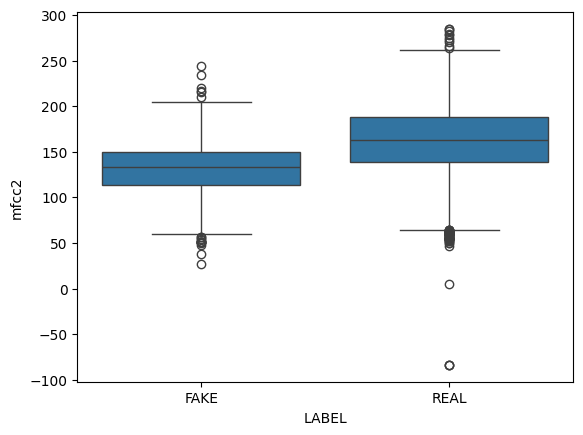

In [ ]:
# generate a boxplot that shows the mfcc2 for fake and real audio samples

# Assuming df is your DataFrame and it has columns 'mfcc2' and 'LABEL'
sns.boxplot(x='LABEL', y='mfcc2', data=df)

<Axes: xlabel='LABEL', ylabel='rolloff'>

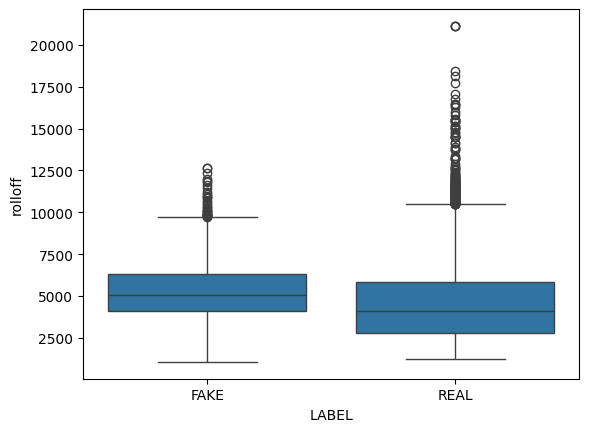

In [ ]:
# generate a boxplot that shows the mfcc2 for fake and real audio samples

# Assuming df is your DataFrame and it has columns 'mfcc2' and 'LABEL'
sns.boxplot(x='LABEL', y='rolloff', data=df)

In [12]:
# Basic NN model, 83-87.5% accuracy on balanced dataset
# 92.68 accuracy on male dataset

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")

# rename 'FAKE' as 1 and 'REAL' as 0 if necessary
if 'FAKE' in df['LABEL'].unique() and 'REAL' in df['LABEL'].unique():
    df['LABEL'] = df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# rename 'label' to 'LABEL' if necessary
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(inplace=False),
            nn.Linear(128, 64),
            nn.ReLU(inplace=False),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


# Training parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_classes = len(np.unique(y))  # Number of unique labels

# 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = SimpleNN(input_size=X.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {accuracy:.4f}")

# Final evaluation on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {correct / total:.4f}")


Fold 1
Epoch 1: Train Loss: 7.3341, Val Loss: 1.4865, Val Acc: 0.7718
Epoch 2: Train Loss: 1.3111, Val Loss: 0.7664, Val Acc: 0.6680
Epoch 3: Train Loss: 1.3085, Val Loss: 0.2439, Val Acc: 0.9253
Epoch 4: Train Loss: 0.6927, Val Loss: 0.2973, Val Acc: 0.9087
Epoch 5: Train Loss: 0.2003, Val Loss: 0.1240, Val Acc: 0.9461
Epoch 6: Train Loss: 0.2401, Val Loss: 0.0511, Val Acc: 0.9834
Epoch 7: Train Loss: 0.1710, Val Loss: 0.0794, Val Acc: 0.9793
Epoch 8: Train Loss: 0.2794, Val Loss: 0.0623, Val Acc: 0.9751
Epoch 9: Train Loss: 0.2903, Val Loss: 0.3930, Val Acc: 0.8548
Epoch 10: Train Loss: 0.4558, Val Loss: 0.4832, Val Acc: 0.8880
Fold 2
Epoch 1: Train Loss: 7.8190, Val Loss: 7.2225, Val Acc: 0.5809
Epoch 2: Train Loss: 1.6122, Val Loss: 0.7419, Val Acc: 0.7469
Epoch 3: Train Loss: 0.8392, Val Loss: 0.7103, Val Acc: 0.8423
Epoch 4: Train Loss: 0.4700, Val Loss: 0.9152, Val Acc: 0.7344
Epoch 5: Train Loss: 1.0667, Val Loss: 0.1510, Val Acc: 0.9461
Epoch 6: Train Loss: 1.2045, Val Loss: 1

In [13]:
# save basic NN model that was just run
# torch.save(model, '/content/drive/My Drive/LING_199/trained_models/male_models/92.68_basic_male_model.pth')

In [52]:
'''
Classification report on Basic NN model
'''

# Get predicted probabilities for the test set
from sklearn.metrics import classification_report

# load 92.68 male model
# model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/92.68_basic_male_model.pth', weights_only=False)

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    logits = model(X_test_tensor)
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()

# Display probabilities for each class
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probabilities[:10]):
    print(f"Sample {i+1}: REAL={prob[0]:.4f}, FAKE={prob[1]:.4f}")

# Convert probabilities to predicted labels
predicted_labels = np.argmax(probabilities, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=["REAL", "FAKE"]))


Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.1133, FAKE=0.8867
Sample 2: REAL=0.9998, FAKE=0.0002
Sample 3: REAL=0.0001, FAKE=0.9999
Sample 4: REAL=0.9988, FAKE=0.0012
Sample 5: REAL=0.0000, FAKE=1.0000
Sample 6: REAL=0.9981, FAKE=0.0019
Sample 7: REAL=0.4820, FAKE=0.5180
Sample 8: REAL=0.9999, FAKE=0.0001
Sample 9: REAL=1.0000, FAKE=0.0000
Sample 10: REAL=0.0113, FAKE=0.9887

Classification Report:
              precision    recall  f1-score   support

        REAL       0.85      1.00      0.92       253
        FAKE       1.00      0.88      0.93       348

    accuracy                           0.93       601
   macro avg       0.93      0.94      0.93       601
weighted avg       0.94      0.93      0.93       601



<ipython-input-47-b8462eb4b034>:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


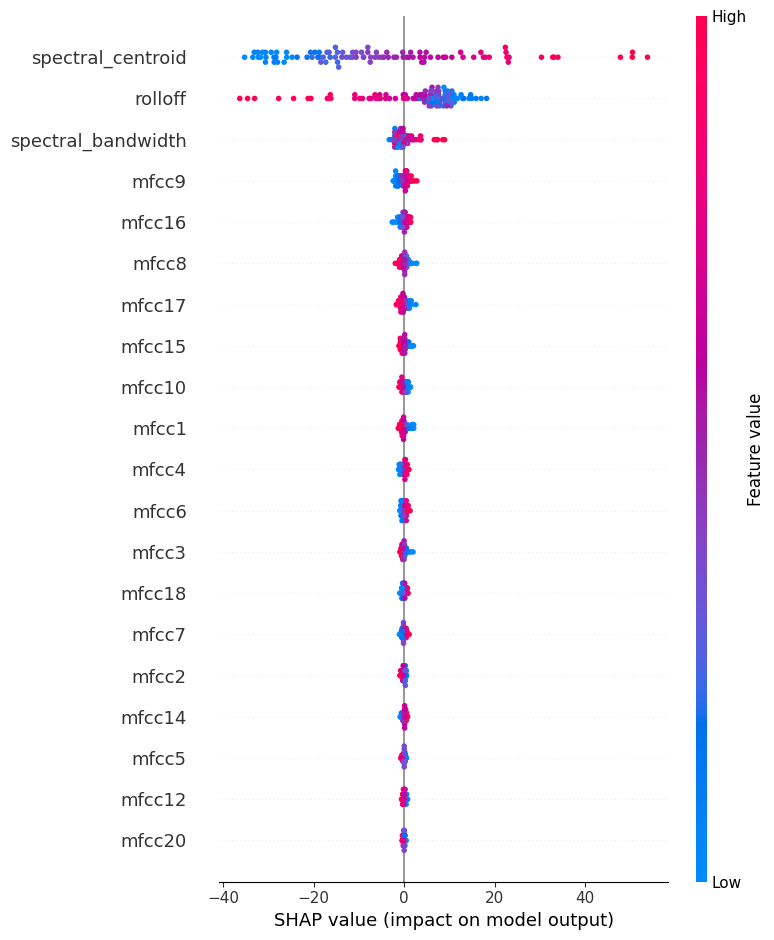

In [47]:
# use shap to visualize feature importance in the basic NN model
# for the male model dataset

import shap

# load basic male model
model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/92.68_basic_male_model.pth', weights_only=False)

# Convert model to evaluation mode
model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor[:100])

'''
transform shap_values shape from (100, 26, 1) to (100, 26)
where 100 is the samples of the test set
and 26 is the number of features
'''
# use this for the improved complex NN model
# shap_values = shap_values.squeeze(-1)

# use this for the basic NN model
# shap_values is (100, 26, 2), select the SHAP values for class 1
shap_values = shap_values[:, :, 1]  # Now shape is (100, 26)


# extract feature names from original dataframe
feature_names = df.drop(columns=['LABEL']).columns.tolist()

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)

In [48]:
# test the basic male model (92.68 train acc) on unseen female dataset

# load the full female data
combined_female_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# Ensure correct column order and drop label if present
feature_names = combined_female_df.columns.drop('label').tolist()
X_new = combined_female_df[feature_names].values  # use same feature_names list from training

# define the device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor and send to device
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

# set the model to evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(X_new_tensor)
    _, predictions = torch.max(outputs, 1)  # For classification

y_new = combined_female_df['label'].values
y_new_tensor = torch.tensor(y_new, dtype=torch.long).to(device)

correct = (predictions == y_new_tensor).sum().item()
accuracy = correct / len(y_new)
print(f"Trained Basic Male Model on Female Dataset Accuracy: {accuracy:.4f}")

Trained Male model on Female Dataset Accuracy: 0.7024


In [ ]:
# Complex NN model, unused ATM
class ComplexNN(nn.Module):
    def __init__(self, input_size):
        super(ComplexNN, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        return self.sigmoid(x)

In [ ]:
# Improved Complex NN model, 98.26% accuracy on full balanced dataset
# 83% accuracy for the male dataset

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Convert LABEL column: 'REAL' -> 0, 'FAKE' -> 1 if necessary
if 'FAKE' in df['LABEL'].unique() and 'REAL' in df['LABEL'].unique():
    df['LABEL'] = df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure shape compatibility

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

import torch
import torch.nn as nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ImprovedComplexNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedComplexNN, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)  # Added BatchNorm
        self.act4 = Swish()  # Swish activation function

        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.act4(x)

        x = self.fc5(x)
        return torch.sigmoid(x)  # Apply Sigmoid at the output layer

# Training parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize the ImprovedComplexNN model
    model = ImprovedComplexNN(input_size=X.shape[1]).to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop

        # set the model to evaluation mode
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {accuracy:.4f}")

# Final evaluation on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {correct / total:.4f}")

In [62]:
# print predicted probabilities of each sample, and classification report
from sklearn.metrics import classification_report

# define device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load a previously trained model, make sure weights only is false
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Display probabilities for each test sample (first 10 rows)
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probs[:10]):
    print(f"Sample {i+1}: REAL={1 - prob:.4f}, FAKE={prob:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=["REAL", "FAKE"]))

Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.0033, FAKE=0.9967
Sample 2: REAL=0.9995, FAKE=0.0005
Sample 3: REAL=0.0064, FAKE=0.9936
Sample 4: REAL=0.9926, FAKE=0.0074
Sample 5: REAL=0.0044, FAKE=0.9956
Sample 6: REAL=0.9998, FAKE=0.0002
Sample 7: REAL=0.0109, FAKE=0.9891
Sample 8: REAL=0.8971, FAKE=0.1029
Sample 9: REAL=0.9320, FAKE=0.0680
Sample 10: REAL=0.0034, FAKE=0.9966

Classification Report:
              precision    recall  f1-score   support

        REAL       0.97      0.95      0.96       253
        FAKE       0.97      0.98      0.97       348

    accuracy                           0.97       601
   macro avg       0.97      0.96      0.97       601
weighted avg       0.97      0.97      0.97       601



In [28]:
# save the model that was just trained

# torch.save(model, '/content/drive/My Drive/LING_199/trained_models/male_models/83._complex_male_model.pth')

<ipython-input-24-aea921cdde01>:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


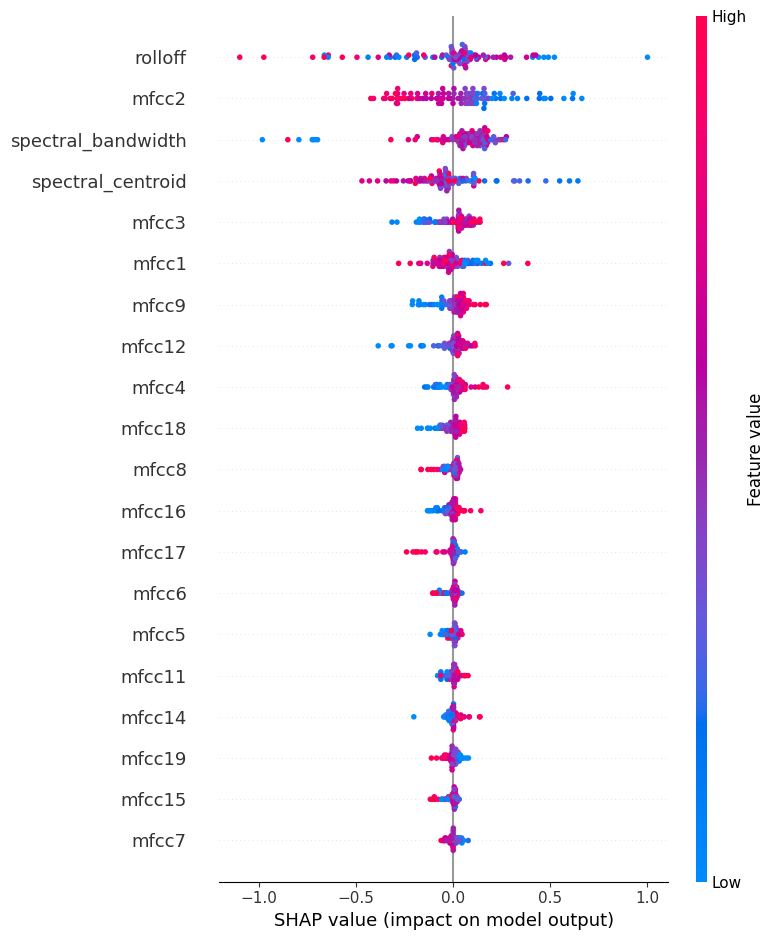

In [ ]:
# use shap to visualize feature importance in the improved Complex NN model
# for the full balanced ML dataset.
# First, we take the trained model, and a small batch of training data for
# shap to compute the baseline model behavior
# Then, we define the shap explainer, and get shap values by running
# the explainer (shap's base model behavior from the small batch of train data)
# on a subset of testing samples from the test data
# Now, each feature has ranked importance, with a shap value that shows how
# important the value is for determining the class for a test sample

import shap

# Convert model to evaluation mode
model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor[:100])

# transform shap_values shape from (100, 26, 1) to (100, 26)
# where 100 is the samples of the test set
# and 26 is the number of features
shap_values = shap_values.squeeze(-1)

# extract feature names from original dataframe
feature_names = df.drop(columns=['LABEL']).columns.tolist()

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


### Interpretation of shap plot
- y-axis has the feature names present in each audio sample
- x-axis is the shap value, which is the impact on model output.
    - positive shap values push the prediction towards the positive class, in this case FAKE (1)
    - negative shap values push the prediction towards the negative class, in this case REAL (0)
- Color (Red = High, Blue = Low)
    - shows whether high or low feature values are associated with pushing predictions towards FAKE or REAL

For instance, we see that MFCC2 is high ranked (important) in explaining the difference between fake and real audio samples, and that as the MFCC2 value goes up (High red color), the class goes to REAL (negative shap value), but as it goes down (Blue low color), the class goes to FAKE (positive shap value).

The higher the MFCC2 value is, the more real the audio sample is, and the lower the MFCC2 value is, the more fake the audio sample is.

In [ ]:
# analysis of the best model
# 98.26 model has highest of 0.9876910016977929 at state 746
# split the data differently and test the model

# load a model
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False)

# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure shape compatibility

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# list of accuracies
acc_list = []

# loop for 1000 different random splits
for i in range(0, 1000):

  # Split into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, stratify=y, random_state=i
  )

  # Create dataset objects
  train_dataset = CustomDataset(X_train, y_train)
  test_dataset = CustomDataset(X_test, y_test)

  # Training parameters
  num_epochs = 10
  batch_size = 32
  learning_rate = 0.001

  # Evaluation on the test set
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          predicted = (outputs > 0.5).float()
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

  acc_list.append(correct / total)

# print descriptive statistics of accuracies
print(f"Max Accuracy: {max(acc_list)}, Random State: {acc_list.index(max(acc_list))}")
print(f"Average Accuracy: {sum(acc_list)/len(acc_list):.4f}")
print(f"Min Accuracy: {min(acc_list)}")

Max Accuracy: 0.9872665534804754, Random State: 159
Average Accuracy: 0.9801
Min Accuracy: 0.9715619694397284


In [ ]:
# test on a new generated dataframe 0 is real, 1 is fake

# load the best model
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False)

# get the extracted features dataframe from way at the beginning
linus_real_df_no_label = linus_real_df.drop(columns=['label'])

# convert this dataframe to a tensor
linus_real_tensor = torch.tensor(linus_real_df_no_label.values, dtype=torch.float32)

# run this data through the model
with torch.no_grad():
    outputs = model(linus_real_tensor.to('cuda'))
    predicted = (outputs > 0.5).float()

# there are 60 rows, one for each second of audio

# the outputs tensor is the probability that each row is fake
# print(outputs.mean())

# predicted object is the tensor where it rounds to 0 or 1 based on if it is above or below 0.5
# for example, one of the values in output is 0.56, that means the model predicted that that row is fake
# thus, predicted object would have that entry at 1
print(predicted.mean())